# Spinal Chord Segmentation

This notebook illustrates how to pre-processed the data (2D 3D, access and transform), build and train a deep learning model (U-net) and finally, get its inferences fro further analysis.


This notebook is meant to describe each step in a sequential. All the functions are stored in the `./src` folder.

#### General imports

In [ ]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd()+'/src/')

In [ ]:
try : #if work on Google Colab (for free GPUs)
    from google.colab import drive
    from google.colab import files
    drive.mount("/content/gdrive/") # access google drive, need permission
    WD = '/content/gdrive/My Drive/Image Segmentation/'
    DATA = WD + '/images_db/'

except ModuleNotFoundError:
    DATA = './images_db/'
    WD = os.getcwd()
    
TRAIN = 'train/'
TEST = 'test/'

# Data Pre-Processing

In [ ]:
from pre_processing import to_numpy_file, crop_center, to_slice_images,\
                           create_2D_masks, mask_majority_voting

In [ ]:
# TRAIN
train_raw_path = 'training-data-gm-sc-challenge-ismrm16-v20160302b/'
#get a list of files
files = [file for file in os.listdir(DATA + train_raw_path) if file.endswith('nii.gz')]
#list fo mask files
mask_files_train = sorted([mask for mask in files if 'mask' in mask ])
#list fo image files
images_files_train = sorted(list(set(files) - set(mask_files_train)))

# TEST 
test_raw_path = 'test-data-gm-sc-challenge-ismrm16-v20160401/'
files = [file for file in os.listdir(DATA + test_raw_path) if file.endswith('nii.gz')]

### Images

The volume of images are split into slices to simplify the problem into 2D segmentation. Computational time would be shorter.

The squared images of the set do not share the same size (ranging from 100 to more thant 600 pixels). To make the set uniform, all the images were resized to an arbitratry shape *S* Two cases were possible :
 - If the images are smaller than *S*, then they are augmented.
 - If the images are larger than *S*, borders are cropped to keep only the center of the image (containing the region of interest)

Finally, the file names are simplified and will match with their corresponding mask.

#### Train

In [ ]:
data_path = DATA + train_raw_path
output_path = DATA + TRAIN + 'images/'

#convert to .npy format
to_numpy_file(data_path, output_path, files= images_files_train , to_int=False)
images_files = [img for img in os.listdir(output_path) if img.endswith('npy')]

In [ ]:
shape = (128,128)
data_path = DATA + TRAIN + 'images/'
output_path = DATA + TRAIN + f'images/2D-crop-{shape[0]}x{shape[0]}/'
# from 3D to 2D images
to_slice_images(data_path, output_path, images_files, shape)

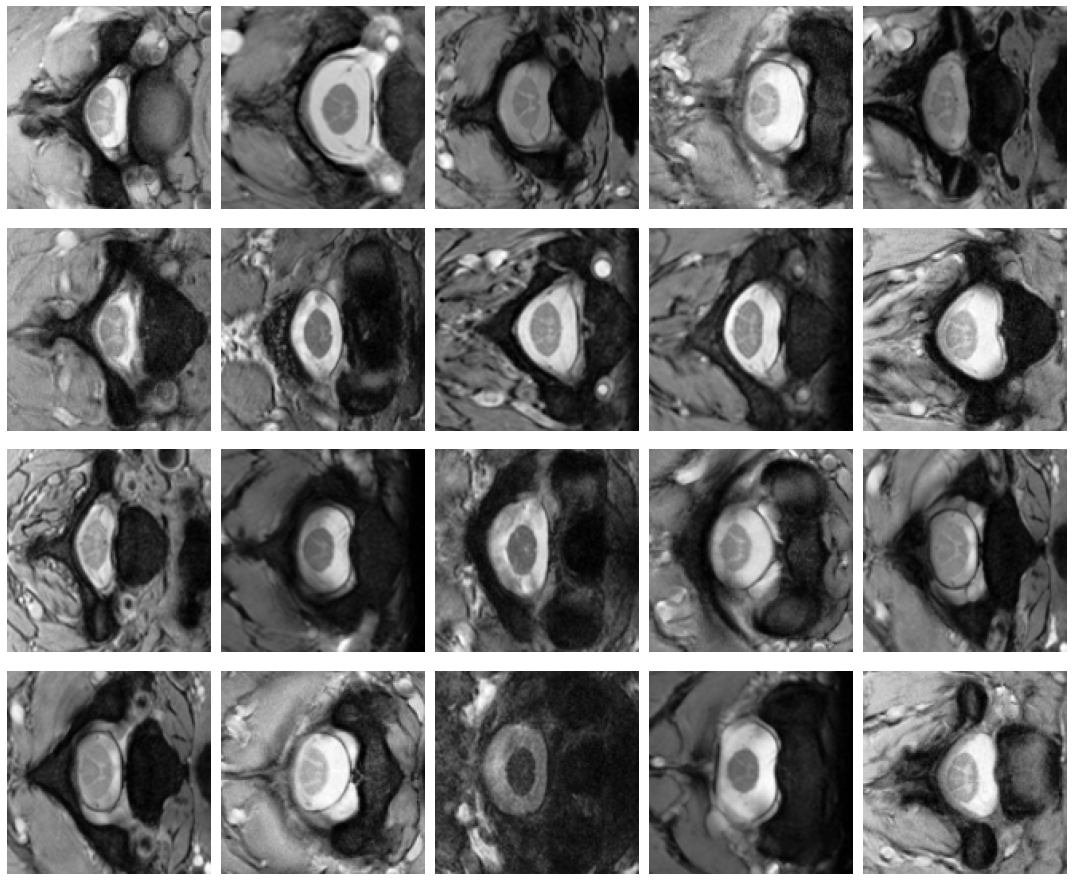

In [ ]:
#plotting - data exploration
fig, axes = plt.subplots(4,5, figsize=(15,12.5))
axes = axes.flatten()
images_files= [x for x in os.listdir(output_path)]
for i in range(20):
    img = np.load(output_path + images_files[i]) #dtype=np.int8)
    axes[i].imshow(img, cmap='Greys_r')
    axes[i].axis('off')
fig.tight_layout()
plt.show()

#### Test

In [ ]:
data_path = DATA + test_raw_path
output_path = DATA + TEST + 'images/'

#convert to .npy format
to_numpy_file(data_path, output_path, files = images_files_test, to_int=False)
images_files = [img for img in os.listdir(output_path) if img.endswith('npy')]

In [ ]:
shape = (128,128)
data_path = DATA + TEST + 'images/'
output_path = DATA + TEST + f'images/2D-crop-{shape[0]}x{shape[0]}/'
# from 3D to 2D images
to_slice_images(data_path, output_path, images_files, shape)

### Masks

The masks have three labels representing the background, the white matter and the grey matter.

The data is composed of a set of four masks (obtained by different technicians) per images. As manual contouring can be prone to errors, the final labels is built from a majority vote system : a pixel is labeled by the class that is the more represented among the four masks.
This would make the labelling more robust.

Afterwards, the masks are reduced to a sequence of 2D images and the same processing as the images is applied. Finally, a channel with binary pixels are created for each label (*e.g.* $[height, width]$ to $[height, width, number\ of \ class]$) : the encoding of the labels has to be read in separed 2D planes.

#### Train

In [ ]:
data_path = DATA + TRAIN 
output_path = DATA + TRAIN 
mask_files = sorted([mask.replace('nii.gz','npy') for mask in mask_files_train])

to_numpy_file(data_path, output_path, files=mask_files, to_int=False)
mask_majority_voting(data_path, output_path, mask_files=mask_files)

In [ ]:
shape = (128, 128)
data_path = DATA+ 'train/masks/' 
output_path = (DATA+ f'train/masks/2D-crop-{shape[0]}x{shape[0]}/' 
mask_files = [mask for mask in os.listdir(DATA + TRAIN + 'masks/') if mask.endswith('npy')]

create_masks(data_path, output_path, mask_files, shape)

# Explore data augmentation

This section is meant to illustrate the data augmentation that is applied on the images.

The data is accessed through `DataGenerators` that would load batches of data and apply random data transformation :
 - Rotation along the spinal axis 
 - Height and widht shifting
 - Normalisation per each frame
 
The transformation has a uniform chance to be applied within the boundaries provided by the user. *E.g* if the a rotation parameter of $r$ is provided, then the images will have a uniform chance to be rotated by a angle of $[-r \ ;+r]$.

In [ ]:
from data_generator import DataGenerator, make_partition

In [ ]:
#get the list of files in each folder
data_folder = '2D-crop-128x128/'
list_IDs = [x for x in os.listdir(DATA + 'train/images/' + data_folder) if x.endswith('.npy')]
list_masks = [m for m in os.listdir(DATA + 'train/masks/' + data_folder) if m.endswith('.npy')]
list_masks = list(set(list_IDs) & set(list_masks))
list_IDs = list(set(list_IDs) & set(list_masks))

#divide into training and vlaidation  folder
partition, labels = make_partition(list_IDs, list_masks, 0.2, random_state=42)

In [ ]:
image_data_path = DATA + 'train/images/' +  data_folder
mask_data_path = DATA + 'train/masks/'  +  data_folder

# datagenerators parameters
dim = (128,128,1)
batch_size = 8
#data augmentaiton parameters
shift=5 
rotate=20

train_gen = DataGenerator(partition['train'], image_data_path,
                          mask_data_path, 
                          shift=shift, rotate=rotate, dim= dim,
                          batch_size=batch_size,
                          shuffle=True, testing=False)

/Users/Jean-BaptistePROST/miniconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


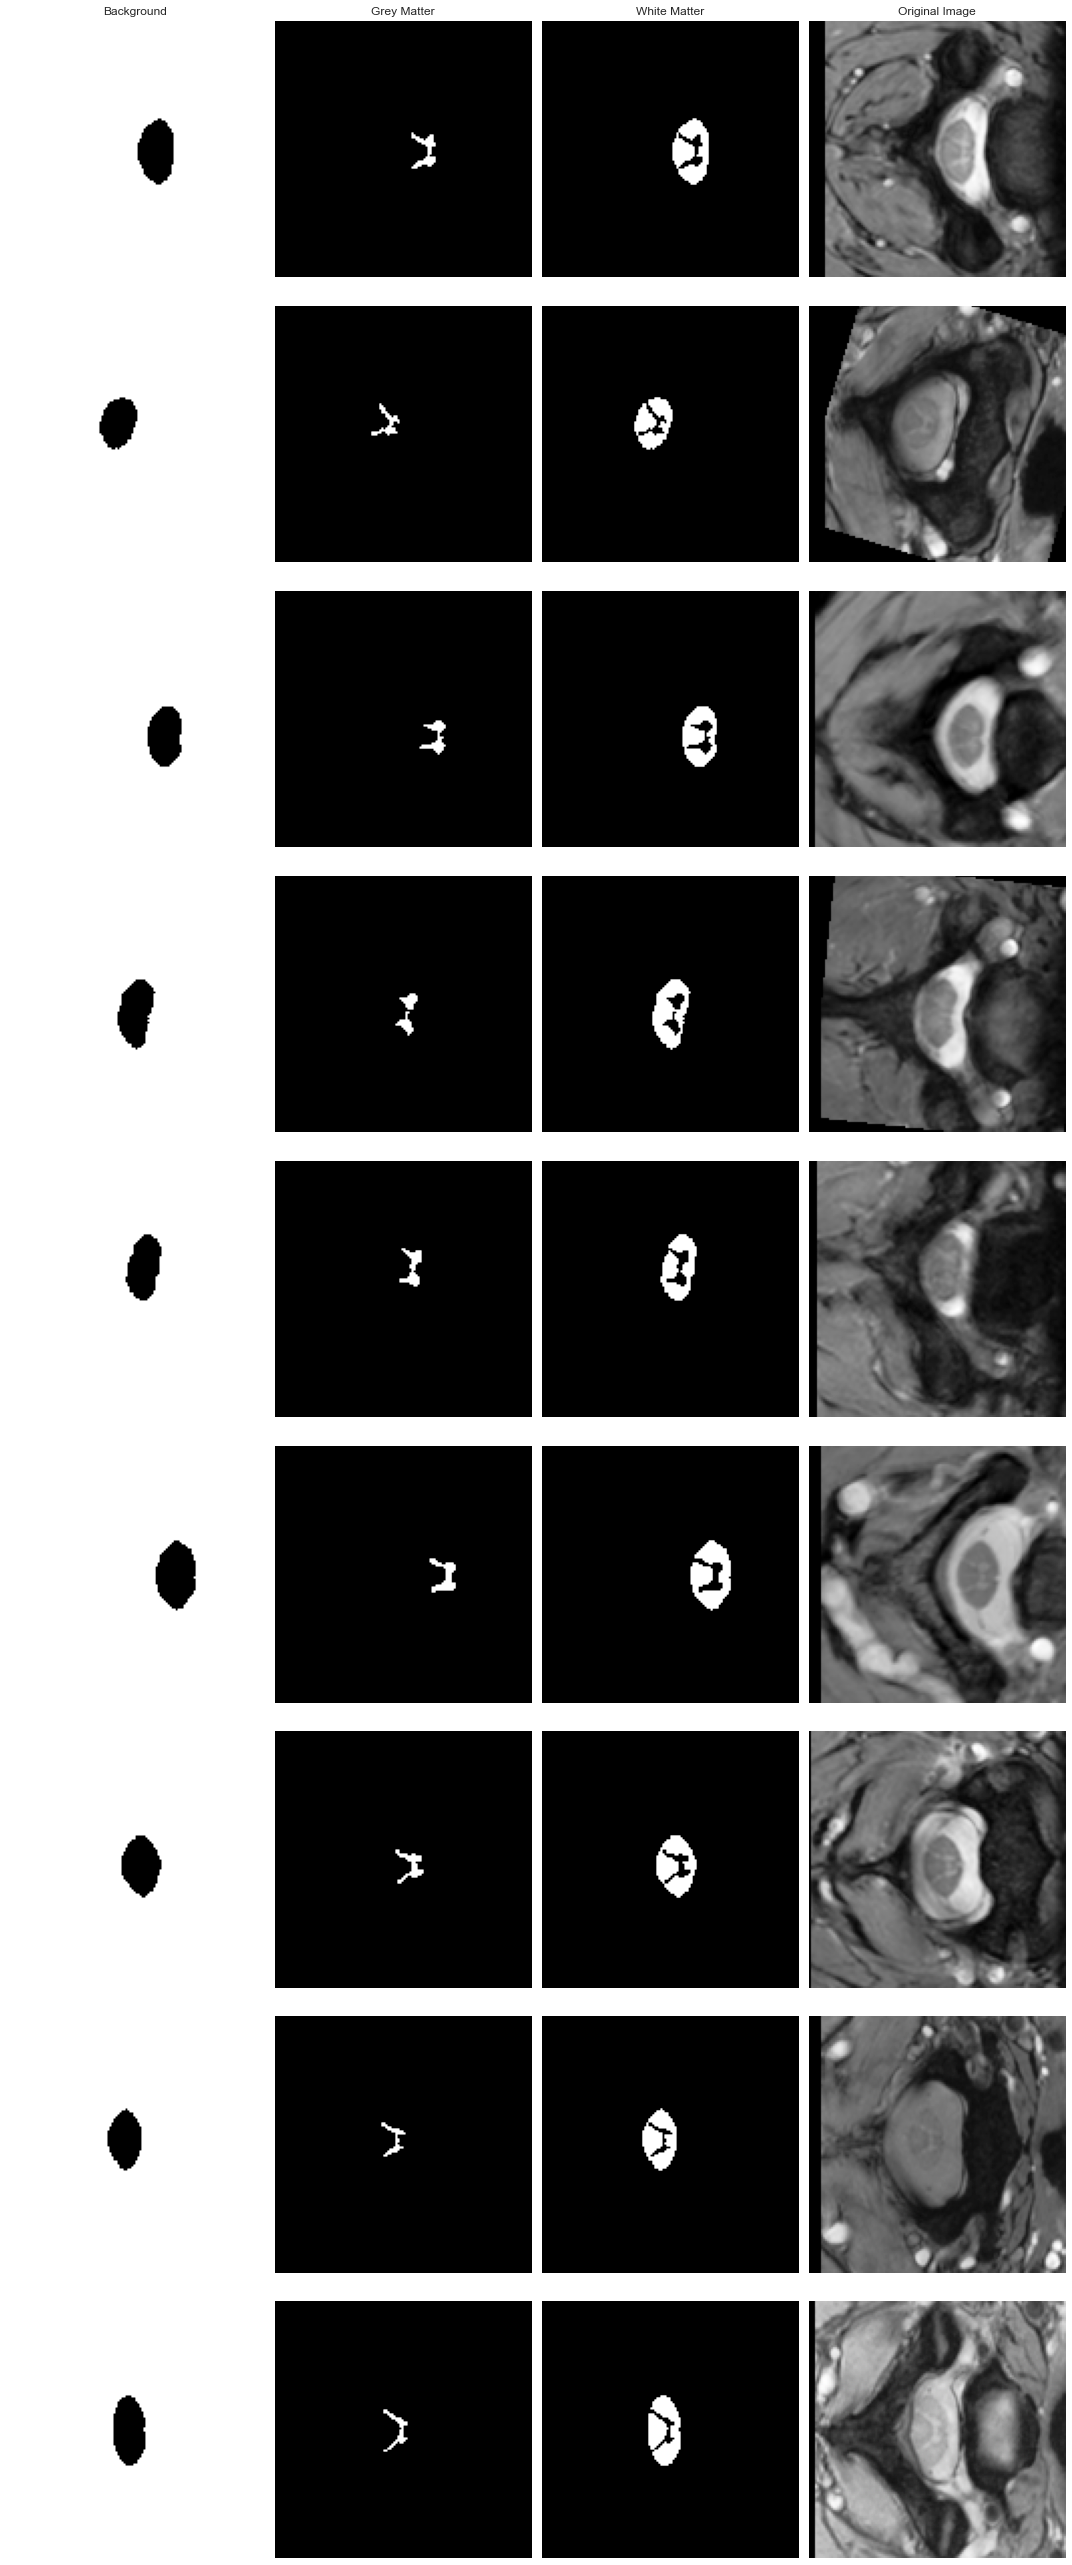

In [ ]:
# plotting
nb_samples = 9
f, axes = plt.subplots(nb_samples,4, figsize = (15,4*nb_samples))

for batch in range(0, int(np.ceil(nb_samples/batch_size))):
    gen = train_gen.__getitem__(batch)
    for j in range(batch_size):
        i = batch*batch_size+j
        if i < nb_samples:
            img = np.clip(gen[0][j],0,1)
            mask = gen[1][j]

            axes[i,0].imshow(mask[:,:,0].astype(np.uint8), cmap='Greys_r')
            axes[i,1].imshow(mask[:,:,1].astype(np.uint8), cmap='Greys_r')
            axes[i,2].imshow(mask[:,:,2].astype(np.uint8), cmap='Greys_r')
            axes[i,3].imshow(img[:,:,0], cmap='Greys_r')

            axes[i,0].axis('off')
            axes[i,1].axis('off')
            axes[i,2].axis('off')
            axes[i,3].axis('off')

axes[0,0].set_title('Background')
axes[0,1].set_title('Grey Matter')
axes[0,2].set_title('White Matter')
axes[0,3].set_title('Original Image')
f.tight_layout()
f.show()

# Deep Learning Model - Cross-validation

In [ ]:
from unet_model import build_unet, Mean_IoU_custom
from sklearn.model_selection import KFold

The model selected is a U-net with four descending and ascending blocks.

As the data splitting was already made, a cross-validation is made to have a better estimation of the model's performance over several input data-sets.

In [ ]:
# data settings
image_data_path = DATA + 'train/images/' +  data_folder
mask_data_path = DATA + 'train/masks/'  +  data_folder
dim = (128,128,1)
batch_size = 8

#building model settings
shape = (128, 128, 1)
num_classes = 3
lr = 1e-3

#stops learning when the validation loss reaches a plateau after 30 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              min_delta=5*1e-4,
                                              patience=10)

#reduce the learning rate when the validation loss reaches a plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=10)

# 5-cross-validation
k_splits = KFold(n_splits=5, shuffle=True, random_state=42).split(list_IDs)
validation_partition = {}
train_partition = {}
validation_prediction = {}
train_prediction = {}

k=0
for train, val in k_splits:
    train = np.array(list_IDs)[train]
    val = np.array(list_IDs)[val]
    train_partition[k] = train
    train_gen = DataGenerator(train, image_data_path,
                          mask_data_path, 
                          shift=5, rotate=20, dim= dim,
                          batch_size=batch_size,
                          shuffle=True, testing=False)
    validation_partition[k] = val
    val_gen = DataGenerator(val, image_data_path,
                          mask_data_path, dim=dim,
                        testing=True)
    
    model = build_unet(shape, num_classes)
    model.compile(loss="categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(lr),
                  metrics=[Mean_IoU_custom(num_classes=3, name='IoU'),
                           tf.keras.metrics.Precision(name='P'),
                           tf.keras.metrics.Recall(name='R')])
    
    #saves the models that has the smaller validation loss
    models_file_path = f"/content/gdrive/My Drive/Image Segmentation/Models/Model{k+1}/"+"epochs{epoch:03d}-val_IoU{val_IoU:.3f}.hdf5"
    model_check_point = tf.keras.callbacks.ModelCheckpoint(models_file_path,
                                      monitor='val_loss', mode='min',
                                      save_best_only=True)

    #training
    print(f'Trainning {k} fold')
    if k==0: # displays training only for the first fold
        verbose=1
    else:
        verbose=3
    
    model.fit(x=train_gen, validation_data = val_gen,
              epochs = 65,
              verbose=verbose,
              callbacks=[early_stop,
                         reduce_lr,
                         model_check_point])
    
    # get predictions
    validation_prediction[k] = model.predict(val_gen, verbose=verbose)
    
    #do nto apply transformation on teh training data for predictions
    train_gen = DataGenerator(train, image_data_path,
                              mask_data_path, dim=dim,
                              testing=True)
    train_prediction[k] = model.predict(train_gen, verbose=verbose)

    k+=1

Trainning 0 fold
Epoch 1/65
44/44 [==============================] - 31s 645ms/step - loss: 1.3123 - IoU: 0.1187 - P: 0.1945 - R: 0.0496 - val_loss: 0.9855 - val_IoU: 0.2583 - val_P: 0.0000e+00 - val_R: 0.0000e+00
Epoch 2/65
44/44 [==============================] - 28s 632ms/step - loss: 0.6287 - IoU: 0.5097 - P: 0.9931 - R: 0.7388 - val_loss: 0.7103 - val_IoU: 0.3876 - val_P: 0.9993 - val_R: 0.5827
Epoch 3/65
44/44 [==============================] - 28s 630ms/step - loss: 0.4405 - IoU: 0.6253 - P: 0.9938 - R: 0.9803 - val_loss: 0.4983 - val_IoU: 0.3336 - val_P: 0.9788 - val_R: 0.9720
Epoch 4/65
44/44 [==============================] - 28s 632ms/step - loss: 0.3102 - IoU: 0.6679 - P: 0.9933 - R: 0.9882 - val_loss: 0.3502 - val_IoU: 0.3647 - val_P: 0.9784 - val_R: 0.9735
Epoch 5/65
44/44 [==============================] - 28s 629ms/step - loss: 0.2209 - IoU: 0.6873 - P: 0.9934 - R: 0.9903 - val_loss: 0.2524 - val_IoU: 0.4185 - val_P: 0.9820 - val_R: 0.9770
Epoch 6/65
44/44 [============

In [ ]:
#stores results
data_path = WD + 'Data/'
pickle.dump(train_partition, open(data_path + 'train_partition.p', 'wb'))
pickle.dump(validation_partition, open(data_path + 'validation_partition.p', 'wb'))
pickle.dump(train_prediction, open(data_path + 'train_prediction.p', 'wb'))
pickle.dump(validation_prediction, open(data_path + 'validation_prediction.p', 'wb'))

The final opertation to implement would be :
 - Train a (*ex novo*) model with the same set of hyper parameters on the entire training set.
 - Generate the test predictions : apply the same pre-processing steps to the test-set (2D, zooming and cropping)

# Model's evaluation

In this section, the model is evaluated by several metrics for each class:
 * Recall : among the class $c$ conditions, how many pixels were effectively labeled as $c$.
 * Precision : among the predicted pixels as class $c$, how many were effictively belonging to $c$.
 * F1 score (Dice Similarity Coefficient) : the overlap over two the predicted and the actual mask.
 * Specificity : the ratio between the number of correclty predicted as non-$c$ over all the non-$c$ predictions.
 * Intersection over Union (IoU) : the porportion similarity between two masks. 
 * Accuracy : number of correctly labelled pixels
 
 
 To get an overall scalar for the mulitclass segmentation the mean of each metrics were computed as follow :
 * Average : take the average of each score among classes
 * Weighted average : weights the average by the proportion of each class. 

In [ ]:
from post_processing import get_predictions_labels, to_binary_results, Metrics, \
                            gather_predictions, plot_scores

data_folder = '2D-crop-128x128/'
image_data_path = DATA + 'train/images/' + data_folder
mask_data_path = DATA + 'train/masks/' + data_folder

### Train

In [ ]:
data_path = WD + '/Data/'
#loads predictions and partition for futur matching
train_partition = pickle.load(open(data_path + 'train_partition.p', 'rb'))
train_prediction = pickle.load(open(data_path + 'train_prediction.p', 'rb'))

,Background,Grey,White,Avg.,Weighted Avg.
Recall,0.9998,0.8610,0.9336,0.9314,0.9976
Precision,0.9988,0.9174,0.9528,0.9564,0.9976
F1 score,0.9990,0.8868,0.9428,0.9430,0.9976
Specificity,0.9584,0.9996,0.9990,0.9858,0.9594
IuO,0.9984,0.7968,0.8920,0.8956,0.9950
Accuracy,0.9984,0.9990,0.9976,0.9982,0.9984
Hausdorff score,1.2196,10.8704,10.8896,7.6600,1.4884


/Users/Jean-BaptistePROST/miniconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


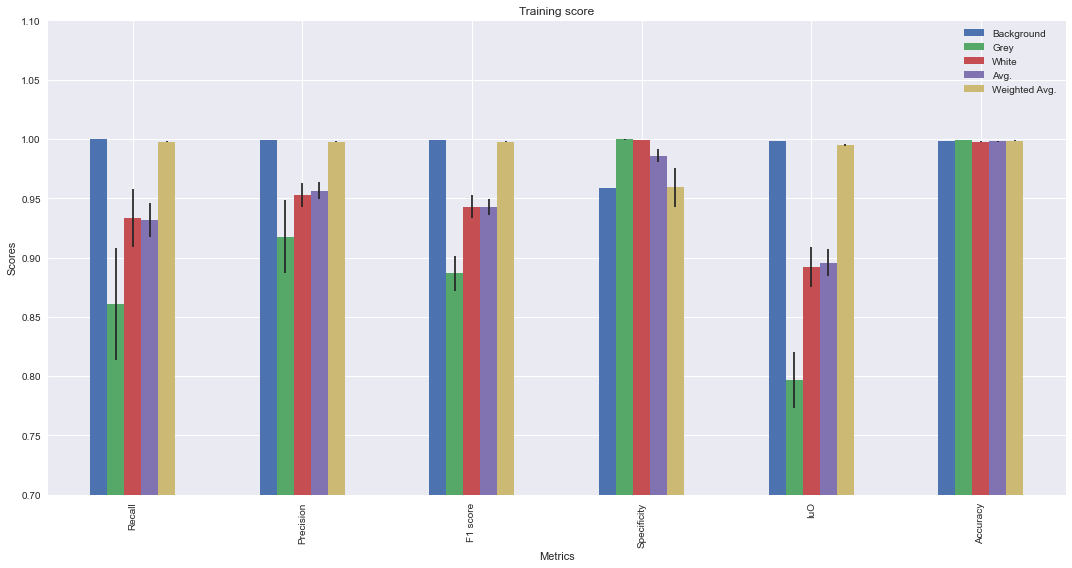

In [ ]:
scores_ks = pd.DataFrame()

# for each fold, gets the training performance
for k in range(5):
    y_pred_raw, y_true_raw = get_predictions_labels(image_data_path,
                                                  mask_data_path,
                                                  train_partition[k],
                                                  train_prediction[k])

    performance = Metrics(y_true_raw, y_pred_raw)
    scores = performance.get_performance()

    if k > 0:
        scores_ks = scores_ks + scores
        scores_std = np.dstack((scores_std, scores.values))
    else:
        scores_ks = scores 
        scores_std = scores.values

#gets the mean of the performance over the 5 folds
df_mean = scores_ks/5
# gets the standard deviation over the 5 folds
df_std = pd.DataFrame(data = scores_std.std(axis=2),
                      columns=['Brackground', 'Grey', 'White', 'Avg.', 'Weighted Avg.'],
                      index=['Recall', 'Precision', 'F1 score', 'Specificity', 'IuO', 'Accuracy', 'Hausdorff score'])

# show scores and plot
display(df_mean)
plot_scores(df_mean, df_std, title='Training score')

### Validation

In [ ]:
data_path = WD + '/Data/'
validation_partition = pickle.load(open(data_path + 'validation_partition.p', 'rb'))
validation_prediction = pickle.load(open(data_path + 'validation_prediction.p', 'rb'))

,Background,Grey,White,Avg.,Weighted Avg.
Recall,0.9992,0.8416,0.9236,0.9216,0.9968
Precision,0.9986,0.9082,0.9434,0.9500,0.9968
F1 score,0.9990,0.8720,0.9332,0.9348,0.9968
Specificity,0.9510,0.9996,0.9988,0.9830,0.9526
IuO,0.9978,0.7736,0.8744,0.8822,0.9940
Accuracy,0.9978,0.9990,0.9968,0.9978,0.9978
Hausdorff score,1.2604,10.8702,10.8890,7.6732,1.5282


/Users/Jean-BaptistePROST/miniconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


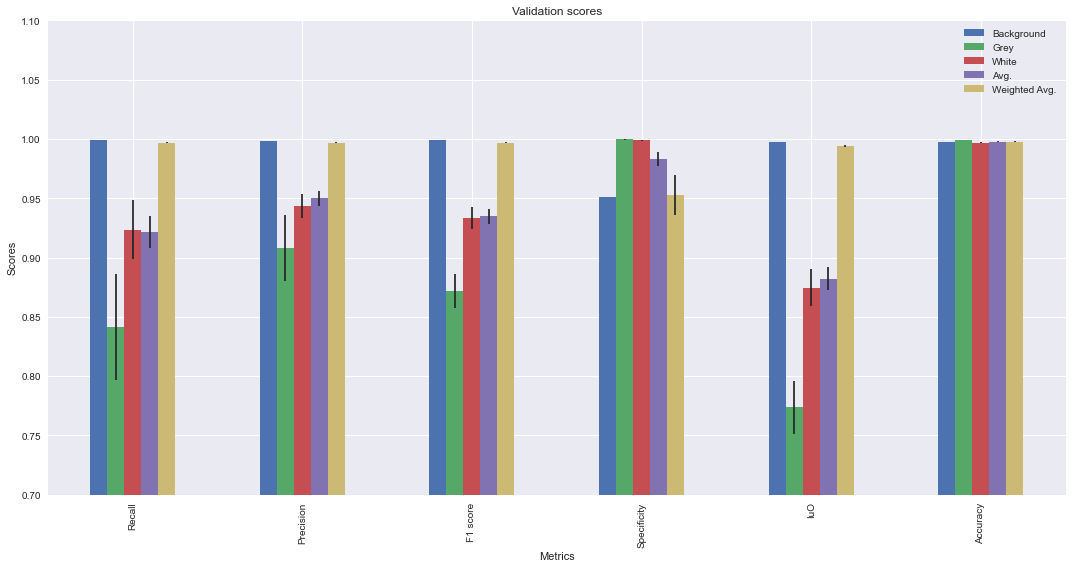

In [ ]:
scores_ks = pd.DataFrame()
# for each fold, gets the validation performance
for k in range(5):
    y_pred_raw, y_true_raw = get_predictions_labels(image_data_path,
                                                  mask_data_path,
                                                  validation_partition[k],
                                                  validation_prediction[k])

    performance = Metrics(y_true_raw, y_pred_raw)
    scores = performance.get_performance()

    if k > 0:
        scores_ks = scores_ks + scores
        scores_std = np.dstack((scores_std, scores.values))
    else:
        scores_ks = scores 
        scores_std = scores.values

#gets the mean of the performance over the 5 folds
df_mean = scores_ks/5
# gets the standard deviation over the 5 folds
df_std = pd.DataFrame(data = scores_std.std(axis=2),
                      columns=['Brackground', 'Grey', 'White', 'Avg.', 'Weighted Avg.'],
                      index=['Recall', 'Precision', 'F1 score', 'Specificity', 'IuO', 'Accuracy', 'Hausdorff score'])

# show scores and plot
display(df_mean)
plot_scores(df_mean, df_std, title='validation score')

#### Gather predictions over each image

As a cross-validation was performed, each label has been at least once in the validation test. Thus an unbiased prediction was generated for each image.
In this subsection, all the inferences are gathered and evaluated.

A confusion matrix eneables to understand where the architecture is doing most of its mistakes.

In [ ]:
# Gathers all validation prediction 
preds_all, labels_all = gather_predictions(image_data_path, mask_data_path,
                                           validation_prediction,
                                           validation_partition)
performance_all_vall = Metrics(labels_all, preds_all)

scores_all_vall = performance_all_vall.get_performance()
conf_mat_all_vall = performance_all_vall.confusion_matrix()

display(scores_all_vall)
display(conf_mat_all_vall)

,Background,Grey,White,Avg.,Weighted Avg.
Recall,0.999,0.842,0.924,0.922,0.997
Precision,0.999,0.906,0.943,0.949,0.997
F1 score,0.999,0.873,0.933,0.935,0.997
Specificity,0.951,1.000,0.999,0.983,0.952
IuO,0.998,0.774,0.875,0.882,0.994
Accuracy,0.998,0.999,0.997,0.998,0.998
Hausdorff score,1.261,10.870,10.889,7.673,1.528


Global [%]             Relative [%]              
           Background  Gray White   Background   Gray  White
True label                                                  
Background      97.17  0.00  0.05        99.94   0.00   0.05
Gray             0.00  0.42  0.07         0.82  84.16  15.02
White            0.13  0.04  2.11         5.79   1.84  92.37

/Users/Jean-BaptistePROST/miniconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


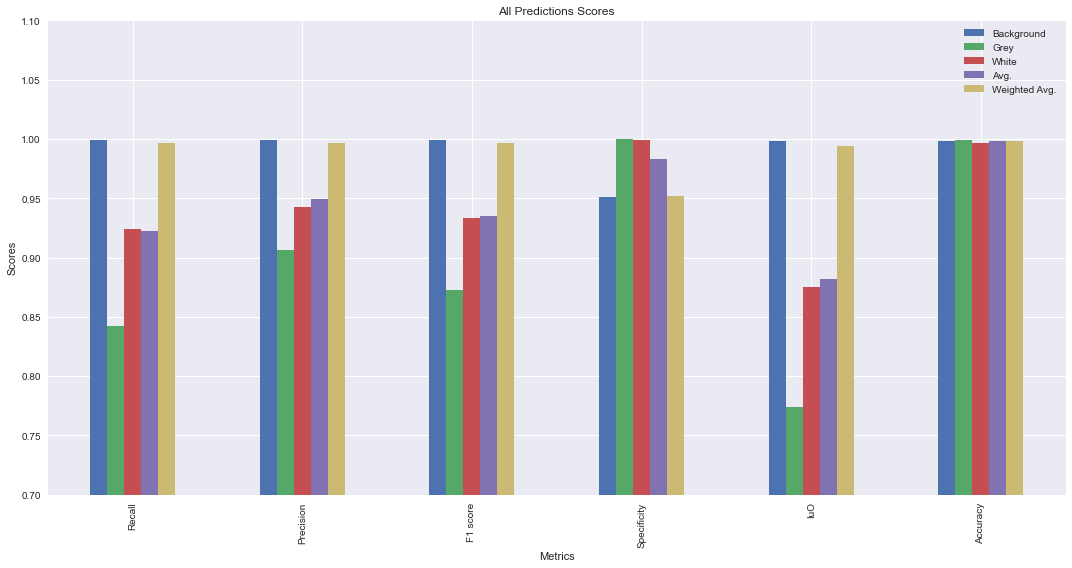

In [ ]:
plot_scores(scores_all_vall, err=None, title='All Predictions Scores')

The *precision vs. recall* curve shows the trade-off between precision and recall for various dicretisation thresholds.

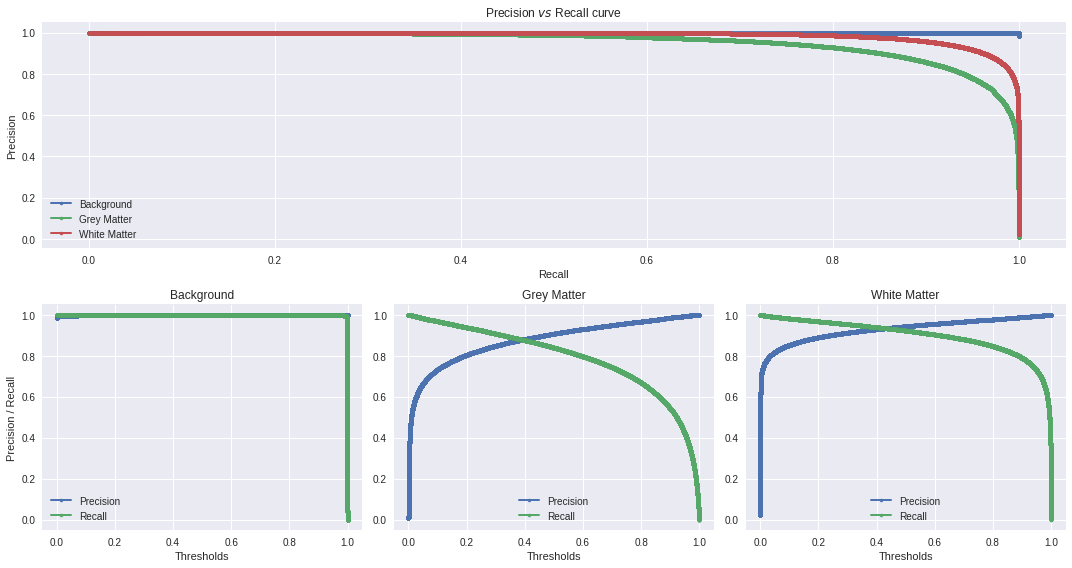

In [ ]:
plot_precision_recall_curve(labels_all, preds_all)

#### Plot results

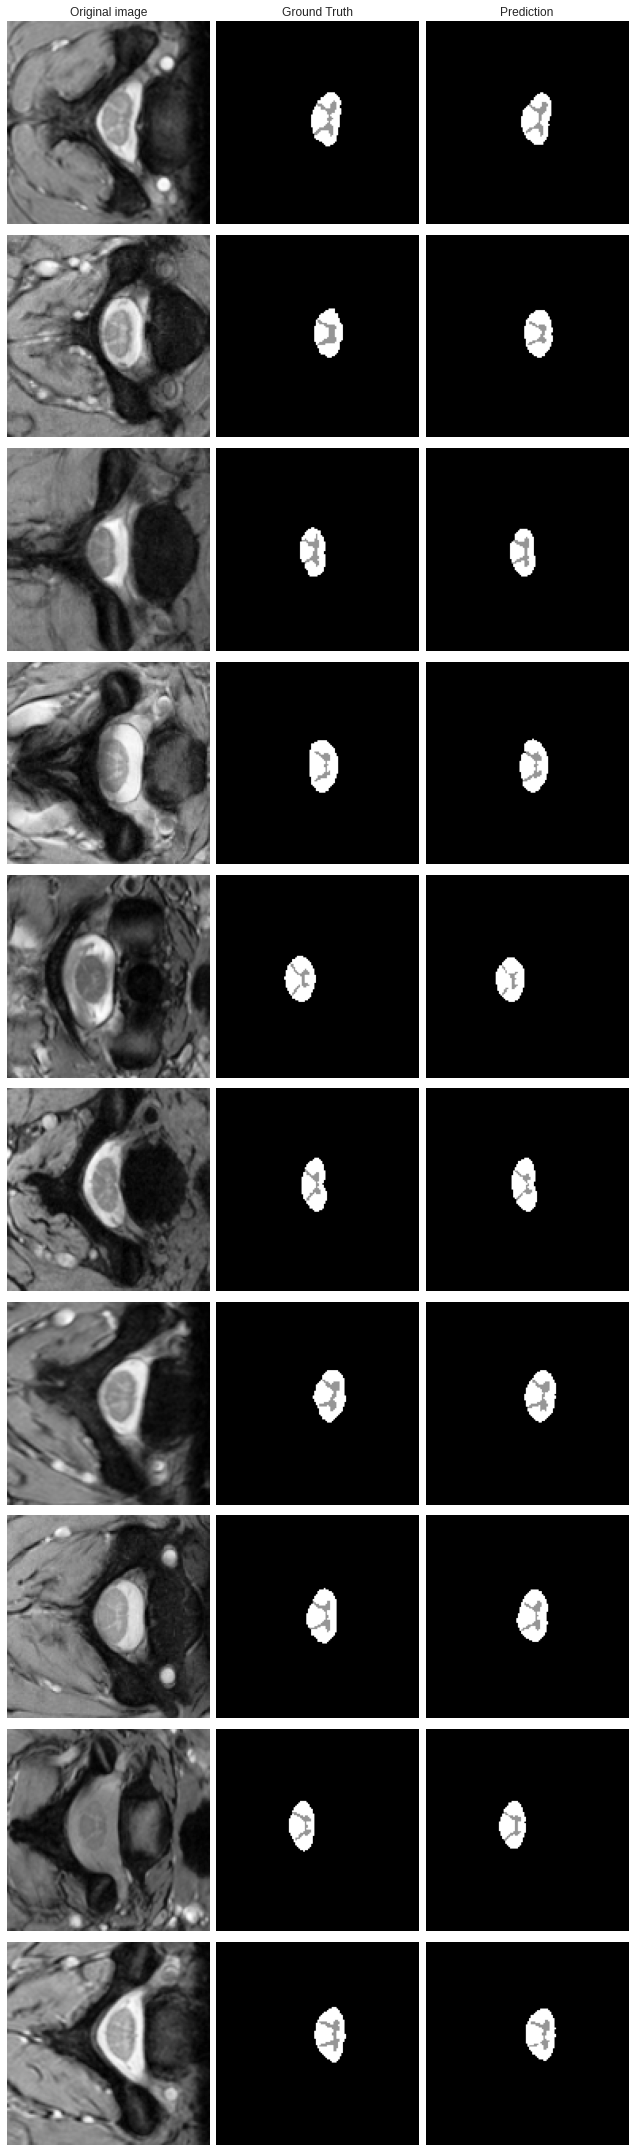

In [ ]:
f, axes = plt.subplots(10,3, figsize = (9,3*10))
for i in range(0, 10):
    ground_t = labels_all[i].argmax(axis=2)
    image = np.load(image_data_path + validation_partition[0][i])
    pred = preds_all[i].argmax(axis=2)
    axes[i,0].imshow(image, cmap='Greys_r')
    axes[i,1].imshow(ground_t, cmap='Greys_r')
    axes[i,2].imshow(pred, cmap='Greys_r')


    axes[i,0].axis('off')
    axes[i,1].axis('off')
    axes[i,2].axis('off')
axes[0,0].set_title('Original image')
axes[0,1].set_title('Ground Truth')
axes[0,2].set_title('Prediction')
f.tight_layout()
f.show()

### Considering a single spinal region 

In [ ]:
y_true_binary = to_binary_results(labels_all)
y_pred_binary = to_binary_results(preds_all)
performance = Metrics(y_true_binary, 
                      y_pred_binary)
scores_binary = performance.get_performance()
display(scores_binary)
conf_mat_binary = performance.confusion_matrix()
display(conf_mat_binary)

,Background,Spine
Recall,0.999,0.952
Precision,0.999,0.980
F1 score,0.999,0.966
Specificity,0.952,0.999
IuO,0.998,0.933
Accuracy,0.998,0.998
Hausdorff score,1.260,10.889


Global [%]       Relative [%]       
           Background Spine   Background  Spine
True label                                     
Background      97.17  0.05        99.94   0.06
Spine            0.13  2.65         4.82  95.18

/Users/Jean-BaptistePROST/miniconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


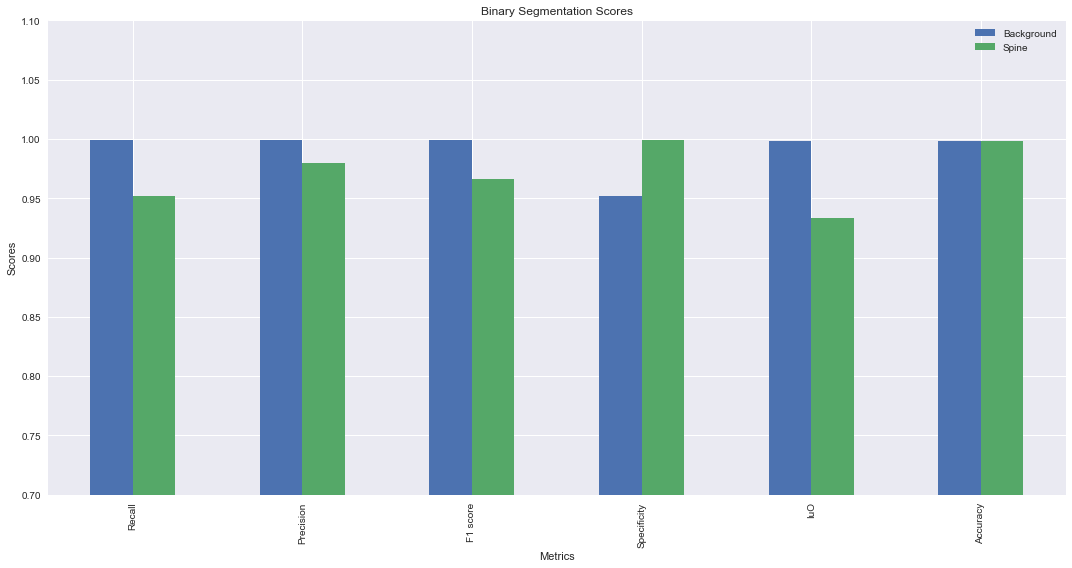

In [ ]:
plot_scores(scores_binary, err=None, title='Binary Segmentation Scores')

# Diagnostic pre-analysis

In [ ]:
from post_processing import isolate_region, get_perimeter, get_rectangularity, \
                            get_compacity, get_elongation, get_height_width, \
                            get_area, get_orientation_angle

The segemtation can be described and quantified by some parameters:
 * Area
 * Perimeter
 * Height and width
 * Rectangularity (ratio between the area of the shape and the area of its circompscripted rectangle)
 * Elongation (ratio between teh height and the width)
 * Orientation (angle of the height of the spine with respect to the "floor" of the scanner)
 * Compacity (defines if a shape has a good area to perimeter ratio)
 
 Those elements could be used as scalars to characterise the spine of the patient

In [ ]:
#get mulitclass labelling
y_pred_discrete = preds_all.argmax(axis=3)

dfs= {}
regions = ['spine', 'white', 'grey']
dfs['grey'] = pd.DataFrame()
dfs['white'] = pd.DataFrame()
dfs['spine'] = pd.DataFrame()

#for every patient get the descriptors for each spine sub-region
for i, prediction in enumerate(y_pred_discrete):
    for region in regions:
        #consider each region seperatly
        pred_tmp = isolate_region(prediction, region)
        #computes the desriptors
        area = get_area(pred_tmp)
        perimeter_ = get_perimeter(pred_tmp)
        height, width = get_height_width(pred_tmp)

        dfs[region].loc[i,'Area'] = area
        dfs[region].loc[i,'Perimeter'] = perimeter_
        dfs[region].loc[i,'Height'] = height
        dfs[region].loc[i,'Width'] = width
        dfs[region].loc[i,'Rectangularity'] = get_rectangularity(height, width, area)
        dfs[region].loc[i,'Elongation'] = get_elongation(height, width)
        dfs[region].loc[i,'Orientation'] = get_orientation_angle(pred_tmp)
        dfs[region].loc[i,'Compacity'] = get_compacity(perimeter_, area) 

df_all = pd.concat((dfs['spine'], dfs['white'], dfs['grey']),
                    axis=1, keys=regions)
df_all.index.name='Patients'

/Users/Jean-BaptistePROST/miniconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


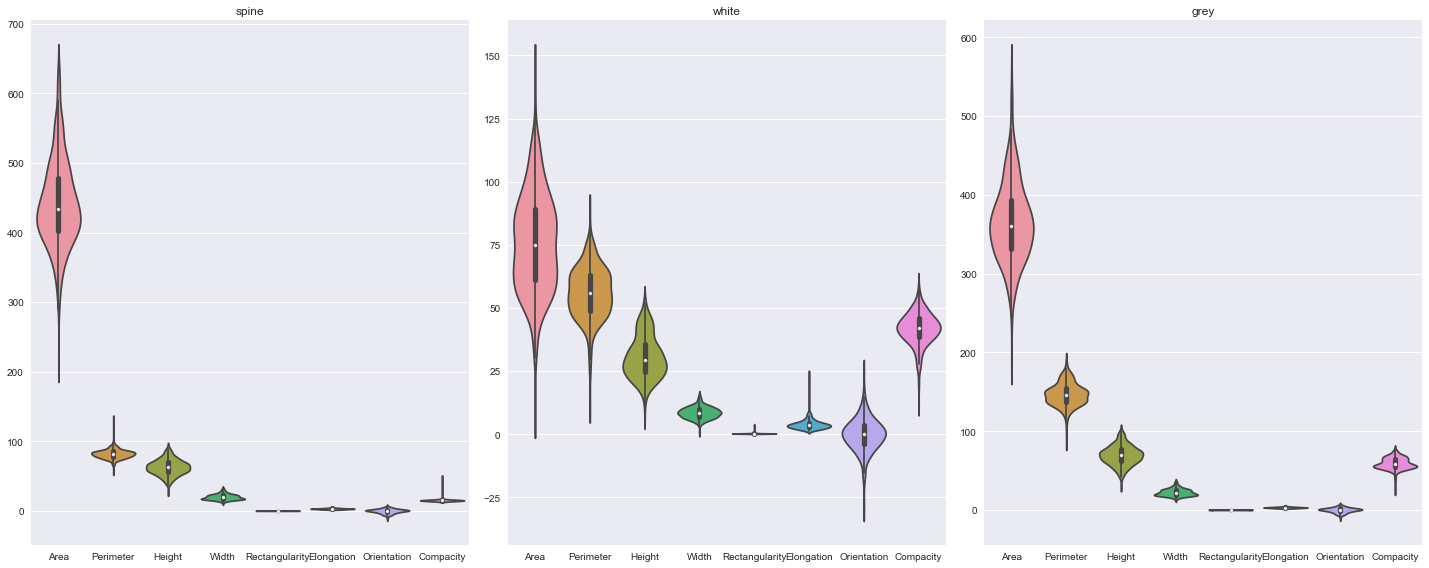

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(20,8))
for i, region in enumerate(regions):
    sns.violinplot(data=df_all[region], ax=axes[i], scale="count")
    axes[i].set_title(region)
fig.tight_layout()
fig.show()

For further analysis each patient could have a description of his/her segmented region.
Thoses features could be fed to a classifier that would detect if a patient suffers (or *is likely to suffer*) from multiple sclerosis.
The input data would look as follow.

In [ ]:
df_all.head()

spine                                                             \
           Area  Perimeter     Height      Width Rectangularity Elongation   
Patients                                                                     
0         458.0  85.597980  67.503230  20.677821       0.328123   3.264523   
1         420.0  79.355339  56.184134  19.969732       0.374338   2.813465   
2         374.0  75.698485  58.091499  15.606527       0.412527   3.722257   
3         459.0  86.183766  69.015954  19.546242       0.340251   3.530907   
4         393.0  73.941125  47.852600  20.530569       0.400024   2.330798   

                                white             ...                         \
         Orientation  Compacity  Area  Perimeter  ... Orientation  Compacity   
Patients                                          ...                          
0          -9.297910  15.997847  94.0  70.284271  ...  -11.396684  52.551902   
1          -0.807952  14.993500  66.0  52.384776  ...   -1.735165  41.578254   
2           2.175262  15.321552  82.0  59.591883  ...   -0.633481  43.307226   
3          -1.423744  16.182226  78.0  62.284271  ...   -5.781024  49.735006   
4          -0.041018  13.911679  46.0  41.313708  ...   -4.186730  37.104837   

           grey                                                              \
           Area   Perimeter     Height      Width Rectangularity Elongation   
Patients                                                                      
0         364.0  158.953319  73.663483  23.542644       0.209891   3.128938   
1         354.0  139.089358  62.933486  21.834053       0.257624   2.882355   
2         292.0  136.568542  65.900857  18.035787       0.245673   3.653894   
3         381.0  152.988853  75.843357  21.976829       0.228582   3.451060   
4         347.0  132.639610  51.054619  22.223275       0.305834   2.297349   

                                 
         Orientation  Compacity  
Patients                         
0          -8.545531  69.412521  
1          -0.779300  54.649292  
2           2.618745  63.873174  
3          -0.940238  61.431992  
4           0.233490  50.701055  

[5 rows x 24 columns]

In [ ]:
df_all.to_csv('./Data/SpinalCharacteristics.csv')